# Capstone Project - Manhatan vs Toronto Resturant Rating
## Ibrahim Albatly - Riyadh - Saudi Arabia

In [22]:
# Import libraries
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import seaborn as sns
import datetime as dt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

print('Libraries imported.')

Libraries imported.


## Gathering and Processing Data from FOURSQUAR
### Part 1 : Manhattan Neighborhoods Dataframe Setup

In [23]:
# Locate New York Locatiobs 
with open('newyork_data1.json') as json_data:
    newyork_data = json.load(json_data)

# Create list of neighborhoods data
neighborhoods_data = newyork_data['features']

# Craete Dataframe of New York 
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)

#Filling in Dataframe 
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

#Manhatan Area 

manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

#Create Manhatan Map 
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

The dataframe has 5 boroughs and 306 neighborhoods.
The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


### Part 2 : Toronto Neighborhoods Dataframe Setup

In [24]:
toronto_data = pd.read_csv('Toronto_Borough.csv' )

del toronto_data['Unnamed: 0']
toronto_data.head()

Borough                            Neighborhood   Latitude  Longitude
0  Scarborough                          Malvern, Rouge  43.806686 -79.194353
1  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535 -79.160497
2  Scarborough       Guildwood, Morningside, West Hill  43.763573 -79.188711
3  Scarborough                                  Woburn  43.770992 -79.216917
4  Scarborough                               Cedarbrae  43.773136 -79.239476

In [25]:
toronto_data.head()
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))
toronto_data.shape[0]


The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


103

In [26]:
#Toronto Area 


#Create Toronto Map 
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Part 3: Explore and Getting Venues Names on Manhaten and Toronto 

In [309]:
# Getting FOURSQUARE API Parameter Ready with Credentails 
CLIENT_ID = 'EGNUN3CLH02DFYOQ3ABCGFIFVQWRTYNLGWPMMZOA44WOD02R' # your Foursquare ID
CLIENT_SECRET = 'P1YRXOGB5FV2F413Q0NBCHN0XGXRKRZKXT3SNO4JPMPGEX20' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

# Latitude and Longtitude on Manhattan
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat,
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue_id',           
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

#Copying to CSV file

# Check Data 
print ('Number of venues gathered in Manhanten is  ',manhattan_venues.shape[0]-1)
print ('Number of venues gathered in Toronto is  ',toronto_venues.shape[0]-1)

manhattan_venues.to_csv('manhattan_venues_all.csv')
toronto_venues.to_csv('toronto_venues_all.csv')




Your credentails:
CLIENT_ID: EGNUN3CLH02DFYOQ3ABCGFIFVQWRTYNLGWPMMZOA44WOD02R
CLIENT_SECRET:P1YRXOGB5FV2F413Q0NBCHN0XGXRKRZKXT3SNO4JPMPGEX20
Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards
Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Mar

### Part 3 :  Additional Details like Price, Facilities , and Rating from FOUSQUARE

In [27]:
manhattan_venues = pd.read_csv('manhattan_venues_all.csv')
toronto_venues = pd.read_csv('toronto_venues_all.csv')
del manhattan_venues['Unnamed: 0']
del toronto_venues['Unnamed: 0']

toronto_venues.head()

Neighborhood  Neighborhood Latitude  \
0                          Malvern, Rouge              43.806686   
1  Rouge Hill, Port Union, Highland Creek              43.784535   
2  Rouge Hill, Port Union, Highland Creek              43.784535   
3       Guildwood, Morningside, West Hill              43.763573   
4       Guildwood, Morningside, West Hill              43.763573   

   Neighborhood Longitude                  Venue_id  \
0              -79.194353  4bb6b9446edc76b0d771311c   
1              -79.160497  4c23d3aaf7ced13a5ed7216d   
2              -79.160497  536bdf8f498ede143cca0072   
3              -79.188711  4beee041e24d20a1cd857314   
4              -79.188711  4c62f34bde1b2d7fec89e370   

                            Venue  Venue Latitude  Venue Longitude  \
0                         Wendy’s       43.807448       -79.199056   
1           Royal Canadian Legion       43.782533       -79.163085   
2  Scarborough Historical Society       43.788755       -79.162438   
3                  RBC Royal Bank       43.766790       -79.191151   
4               G & G Electronics       43.765309       -79.191537   

         Venue Category  
0  Fast Food Restaurant  
1                   Bar  
2        History Museum  
3                  Bank  
4     Electronics Store

In [28]:
#manhattan_venues.head()
#4b4429abf964a52037f225e3


CLIENT_ID = 'EGNUN3CLH02DFYOQ3ABCGFIFVQWRTYNLGWPMMZOA44WOD02R' # your Foursquare ID
CLIENT_SECRET = 'H0G53TXJBKWBMLW5GY40K5AZSPXIV5F4FMXIAL542NNYKI1Y' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


manhattan_venues['price'] = None
manhattan_venues['rating'] = None
manhattan_venues['rating_color'] = None
manhattan_venues['rating_counts'] = None
manhattan_venues['open_days'] = None
manhattan_venues['open_hours'] = None
manhattan_venues['is_reservation'] = None
manhattan_venues['is_wi_fi'] = None
manhattan_venues['is_parking'] = None
manhattan_venues['is_outdoor_Seating'] = None

toronto_venues['price'] = None
toronto_venues['rating'] = None
toronto_venues['rating_color'] = None
toronto_venues['rating_counts'] = None
toronto_venues['open_days'] = None
toronto_venues['open_hours'] = None
toronto_venues['is_reservation'] = None
toronto_venues['is_wi_fi'] = None
toronto_venues['is_parking'] = None
toronto_venues['is_outdoor_Seating'] = None


toronto_venues.head()

Neighborhood  Neighborhood Latitude  \
0                          Malvern, Rouge              43.806686   
1  Rouge Hill, Port Union, Highland Creek              43.784535   
2  Rouge Hill, Port Union, Highland Creek              43.784535   
3       Guildwood, Morningside, West Hill              43.763573   
4       Guildwood, Morningside, West Hill              43.763573   

   Neighborhood Longitude                  Venue_id  \
0              -79.194353  4bb6b9446edc76b0d771311c   
1              -79.160497  4c23d3aaf7ced13a5ed7216d   
2              -79.160497  536bdf8f498ede143cca0072   
3              -79.188711  4beee041e24d20a1cd857314   
4              -79.188711  4c62f34bde1b2d7fec89e370   

                            Venue  Venue Latitude  Venue Longitude  \
0                         Wendy’s       43.807448       -79.199056   
1           Royal Canadian Legion       43.782533       -79.163085   
2  Scarborough Historical Society       43.788755       -79.162438   
3                  RBC Royal Bank       43.766790       -79.191151   
4               G & G Electronics       43.765309       -79.191537   

         Venue Category price rating rating_color rating_counts open_days  \
0  Fast Food Restaurant  None   None         None          None      None   
1                   Bar  None   None         None          None      None   
2        History Museum  None   None         None          None      None   
3                  Bank  None   None         None          None      None   
4     Electronics Store  None   None         None          None      None   

  open_hours is_reservation is_wi_fi is_parking is_outdoor_Seating  
0       None           None     None       None               None  
1       None           None     None       None               None  
2       None           None     None       None               None  
3       None           None     None       None               None  
4       None           None     None       None               None

In [353]:

CLIENT_ID = 'EGNUN3CLH02DFYOQ3ABCGFIFVQWRTYNLGWPMMZOA44WOD02R' # your Foursquare ID
CLIENT_SECRET = 'QWH2YCMFWHXASS15YGBTULLEGASR15J5BTJLS53BXMHZS4RH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

def get_venue_details_man(venue_id,venue_name,m,failed,success):
    VEN_ID = venue_id
    ven_index = m
    rating = None
    url2 = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(VEN_ID,CLIENT_ID, CLIENT_SECRET, VERSION)
    results_2 = requests.get(url2).json()
    try:
        price = results_2['response']['venue']['price']['message']
    except:
        price = None
    try:
        rating = float(results_2['response']['venue']['rating'])
    except:
        rating = None
    try:    
        rating_color =results_2['response']['venue']['ratingColor']
    except:
        rating_color = None
    try:
        rating_counts = results_2['response']['venue']['ratingSignals']
    except:
        rating_counts = None
    try:
        open_days = results_2['response']['venue']['hours']['timeframes'][0]['days']
    except:
        open_days = None
    try:
        open_hours = results_2['response']['venue']['hours']['timeframes'][0]['open'][0]['renderedTime']
    except:
        open_hours = None

    try:
        ven_feature = results_2['response']['venue']['attributes']['groups']
    except:
        ven_feature = None
    
    is_reservation = None
    is_outdoor_Seating = None
    is_wi_fi = None
    is_parking = None  
    if (ven_feature != None):
        i = len(ven_feature) - 1
    else:
        i = -1
    while ((i != -1) and (ven_feature!=None)):
        if ((ven_feature[i]['name'] == 'Reservations') and (ven_feature[i]['items'][0]['displayValue'] == 'No')):
            is_reservation = False
        elif ((ven_feature[i]['name'] == 'Reservations') and (ven_feature[i]['items'][0]['displayValue'] == 'Yes')):
            is_reservation = True
        if ((ven_feature[i]['name'] == 'Outdoor Seating') and (ven_feature[i]['items'][0]['displayValue'] == 'No')):
            is_outdoor_Seating = False
        elif ((ven_feature[i]['name'] == 'Outdoor Seating') and (ven_feature[i]['items'][0]['displayValue'] == 'Yes')):
            is_outdoor_Seating = True
        if ((ven_feature[i]['name'] == 'Wi-Fi') and (ven_feature[i]['items'][0]['displayValue'] == 'No')):
            is_wi_fi = False
        elif ((ven_feature[i]['name'] == 'Wi-Fi') and (ven_feature[i]['items'][0]['displayValue'] == 'Yes')):
            is_wi_fi = True
        if (ven_feature[i]['name'] == 'Parking'):
            is_parking = True
        else:
            is_parking = False
        i = i -1
    if (rating == None): 
        print (m,venue_name, ' Failed',rating)
        failed = failed + 1
    else: 
        print (m,venue_name, ' Success',rating)
        success = success + 1
    manhattan_venues['price'][m] = price
    manhattan_venues['rating'][m] = rating
    manhattan_venues['rating_color'][m] = rating_color
    manhattan_venues['rating_counts'][m] = rating_counts
    manhattan_venues['open_days'][m] = open_days
    manhattan_venues['open_hours'][m] = open_hours
    manhattan_venues['is_reservation'][m] = is_reservation
    manhattan_venues['is_outdoor_Seating'][m] = is_outdoor_Seating
    manhattan_venues['is_wi_fi'][m] = is_wi_fi
    manhattan_venues['is_parking'][m] = is_parking



j = manhattan_venues.shape[0] - 1
print ('to get ',j,'venues details from Foursquare')
m = 0
failed = 0
success = 0
while j!= -1:
    get_venue_details(manhattan_venues['Venue_id'][m],manhattan_venues['Venue'][m],m,failed,success)
    j = j - 1
    m = m + 1

print ('Done !!: Success is ',success, 'Failed is ',failed)
manhattan_venues.to_csv('manhattan_venues_details.csv')





to get  3092 venues details from Foursquare
0 Arturo's  Success 7.9


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value i

1 Bikram Yoga  Success 8.8
2 Tibbett Diner  Success 8.4
3 Starbucks  Success 8.0
4 Dunkin'  Success 7.5
5 Rite Aid  Success 7.0
6 TCR The Club of Riverdale  Success 7.5
7 Land & Sea Restaurant  Success 7.5
8 Starbucks  Success 7.3
9 Astral Fitness & Wellness Center  Success 7.3
10 Blink Fitness  Success 7.4
11 Vitamin Shoppe  Success 7.1
12 Parrilla Latina  Success 7.0
13 T.J. Maxx  Success 7.2
14 Boston Market  Success 7.1
15 Subway Sandwiches  Success 6.6
16 Baskin-Robbins  Success 6.9
17 Lot Less Closeouts  Success 7.2
18 GameStop  Success 6.7
19 TD Bank  Success 6.8
20 Subway  Success 7.0
21 The Children's Place  Success 6.6
22 Five Below  Success 6.9
23 Subway  Success 6.6
24 Broadway Plaza  Success 6.5
25 Terrace View Delicatessen  Failed None
26 Cheeky Sandwiches  Success 9.0
27 Kiki's  Success 9.1
28 Hotel 50 Bowery NYC  Success 8.9
29 Renew Day Spa  Success 8.7
30 Michaeli Bakery  Success 8.9
31 Scarr's Pizza  Success 8.8
32 Bar Belly  Success 8.6
33 Museum at Eldridge Street 

253 John's Fried Chicken  Success 7.3
254 Cafe Tabaco y Ron  Success 7.6
255 El Tina Seafood Restaurant  Success 7.3
256 Baskin-Robbins  Success 6.8
257 La Nueva España  Success 6.8
258 disFruta  Success 7.1
259 Empanadas Monumental  Success 6.9
260 Azteca  Failed None
261 Skyline Lounge  Success 7.0
262 Domino's Pizza  Success 6.8
263 Little Caesars Pizza  Success 6.5
264 Floridita Resturant  Success 6.3
265 Fine Fare  Success 6.0
266 Skyline Bar Lounge  Success 5.9
267 Liquid Skin Studio  Failed None
268 Post Avenue & West 204th Street  Failed None
269 El Mundo  Failed None
270 MTA MaBSTOA Bus Bx12 / +SBS at 207th Street / 10th Avenue  Failed None
271 Super Associated Marketplace  Failed None
272 Cafe One  Success 8.5
273 R.O.K.C  Success 8.9
274 Fumo  Success 9.0
275 Bikram Yoga Harlem  Success 8.7
276 Oso  Success 8.3
277 The Grange Bar & Eatery  Success 8.3
278 Wat’s On Your Plate  Success 8.6
279 Anchor Wine Bar  Success 8.4
280 Brahman Yoga Studio  Success 8.4
281 Uncle Tony's P

487 Ukrainian Institute of America  Success 8.2
488 Central Park - Group of Bears  Success 8.6
489 The Simone  Success 8.4
490 James Michael Levin Playground  Success 9.0
491 The Surrey  Success 8.2
492 Antonucci  Success 8.2
493 Parma Restaurant  Success 8.0
494 The Met Breuer  Success 8.8
495 Metropolitan Museum Steps  Success 9.3
496 Tiramisu  Success 8.0
497 Butterfield Market  Success 7.5
498 By the Way Bakery  Success 8.8
499 Amber  Success 8.0
500 Y7 – Upper East Side  Success 9.0
501 Bottle & Soul  Success 7.7
502 Flora Bar  Success 8.4
503 Orsay  Success 8.2
504 Bode NYC - Upper East Side  Success 8.8
505 Arts of Africa, Oceania and the Americas  Success 8.8
506 The Great Hall  Success 9.1
507 SoulCycle East 83rd  Success 9.2
508 Eli's Market  Success 7.9
509 Pig Heaven  Success 7.8
510 Apple Upper East Side  Success 8.5
511 Caffe Buon Gusto - Manhattan  Success 8.9
512 Levain Bakery  Success 9.4
513 Joe the Art of Coffee  Success 8.3
514 Paper Source  Success 9.0
515 McCabes 

731 Pizza Park  Success 8.2
732 Chase Bank  Success 7.3
733 Oath Pizza  Success 8.0
734 Men's Wearhouse  Success 7.2
735 Otte Third Avenue  Success 7.3
736 lululemon athletica  Success 8.4
737 Pilates Reforming New York - E. 76th St  Success 8.4
738 The Playroom NYC  Success 7.7
739 DAVIDsTEA  Success 8.5
740 Joe the Art of Coffee  Success 8.3
741 Numero 28 Pizza  Success 7.7
742 The Pony Bar  Success 7.9
743 BHLDN  Success 7.2
744 Sur La Table  Success 8.0
745 Benefit Cosmetics Boutique  Success 7.6
746 House of Jai Yoga  Success 8.0
747 NISI  Success 8.2
748 Roosevelt Island Promenade  Success 9.1
749 Roosevelt Island Farmer's Market  Success 7.9
750 Manhattan Park  Success 8.9
751 East Side River Walk  Success 8.8
752 PS 217  Success 7.3
753 Island Wine & Spirits  Success 7.2
754 One East River Place  Success 8.1
755 Wholesome Factory  Success 6.8
756 Subway  Success 6.7
757 Fuji East  Success 6.8
758 Starbucks  Success 6.4
759 Manhattan Park Gym  Success 6.4
760 Roosevelt Island Be

962 YOTEL New York  Success 8.0
963 Pod Times Square  Success 8.5
964 Capizzi  Success 8.7
965 Ada’s Place  Success 8.1
966 M Club at MiMA  Success 7.9
967 Life Time Sky  Success 9.3
968 Oslo Coffee Roasters  Success 8.5
969 Brooklyn Fare  Success 9.0
970 West Side Steakhouse  Success 7.9
971 Yotel - Rooftop Cinema Club  Success 7.9
972 Baryshnikov Arts Center  Success 8.7
973 Shorty's  Success 8.4
974 Sea Breeze Fish Market  Success 8.5
975 Sunac Natural Food  Success 8.1
976 505W37  Success 8.3
977 The Westside Theater  Success 8.3
978 DiMenna Center for Classical Music  Success 8.6
979 Voices of Gotham  Success 8.1
980 Veritas Studio Wines  Success 8.8
981 TITLE Boxing Club NYC - Midtown West  Success 8.5
982 The Actors Studio  Success 8.1
983 La Vela Dining & Bar  Success 8.2
984 Chef's Table At Brooklyn Fare  Success 8.5
985 Ample Hills Creamery  Success 9.0
986 The Alice Griffin Jewel Box Theatre  Success 7.7
987 Legacy Records  Success 7.8
988 Astro Dog Run  Success 7.6
989 Terr

1192 Chrysler Building  Success 8.7
1193 The William  Success 7.8
1194 Poketeria  Success 8.6
1195 Walters Pet Styles  Success 8.1
1196 CrossFit Solace  Success 8.9
1197 Trader Joe's  Success 9.2
1198 The Capital Grille  Success 8.3
1199 Montagu's Gusto  Success 8.2
1200 Meyers Bageri  Success 8.7
1201 Grand Central Terminal  Success 9.0
1202 Grand Central Market  Success 8.9
1203 Vezzo Thin Crust Pizza  Success 8.9
1204 The Langham, New York, Fifth Avenue  Success 8.8
1205 Xi'an Famous Foods  Success 8.7
1206 Willner Chemists  Success 7.8
1207 Docks Oyster Bar  Success 7.5
1208 Le Botaniste  Success 8.6
1209 Baby Bo's Cantina  Success 8.1
1210 CAVA  Success 7.9
1211 mang'Oh yoga  Success 8.6
1212 Windsor Wine Shop  Success 8.0
1213 Grand Hyatt Grand Club  Success 8.0
1214 The Shakespeare  Success 7.5
1215 Ai Fiori  Success 8.6
1216 Cafe Grumpy  Success 8.2
1217 Buttercup Bake Shop  Success 8.0
1218 Rocky's Pizzeria  Success 8.0
1219 Simit Sarayı  Success 8.0
1220 JOE & THE JUICE  Succ

1429 Good Beer NYC  Success 9.2
1430 Kura  Success 9.2
1431 Boris & Horton  Success 9.1
1432 Smør  Success 9.0
1433 Westville East  Success 9.0
1434 Tompkins Square Park Dog Run  Success 9.0
1435 Tompkins Square Bagels  Success 8.9
1436 Cafe Mogador  Success 8.9
1437 Gomi  Success 8.8
1438 Joe & Pat's Pizzeria and Restaurant  Success 8.8
1439 Raclette  Success 8.7
1440 Hanoi House  Success 8.7
1441 Tompkins Square Park  Success 8.7
1442 Barnyard  Success 8.9
1443 Ninth Street Espresso  Success 8.7
1444 Juice Vitality  Success 9.4
1445 Confectionery!  Success 8.6
1446 Maiden Lane  Success 8.7
1447 Xe Máy Sandwich Shop  Success 8.8
1448 Ray's Candy Store  Success 8.6
1449 Avant Garden  Success 8.9
1450 Miss Lily's 7A  Success 8.9
1451 Mikey Likes It Ice Cream  Success 8.5
1452 Crif Dogs  Success 8.5
1453 convive  Success 8.5
1454 Pylos  Success 8.9
1455 Russo’s Mozzarella & Pasta  Success 9.3
1456 TabeTomo  Success 8.4
1457 Village Square Pizza  Success 8.4
1458 Ruffian Wine Bar & Chef's

1669 Eileen's Special Cheesecake  Success 8.9
1670 New York Pilates - Soho  Success 8.9
1671 House Special 甘來飯店  Success 8.2
1672 Wine Therapy  Success 8.8
1673 CAVA  Success 9.2
1674 La Esquina  Success 8.5
1675 Magic Jewelry  Success 8.9
1676 Zooba  Success 8.1
1677 Taïm Falafel and Smoothie Bar  Success 9.1
1678 Uncle Boons  Success 9.1
1679 oo35mm.com  Success 8.9
1680 Osteria Morini  Success 8.7
1681 Spring Café  Success 8.6
1682 citizenM Bowery  Success 9.2
1683 Jack's Wife Freda  Success 8.5
1684 Ruby's Café  Success 9.0
1685 Mother's Ruin  Success 8.4
1686 Mian Tian Sing Hair Salon  Success 8.4
1687 Manero’s Pizza  Success 7.8
1688 Brodo  Success 9.0
1689 Nam Son Vietnamese Restaurant  Success 8.2
1690 Canal Street Market  Success 8.4
1691 Fay Da Bakery  Success 8.2
1692 Ed's Lobster Bar  Success 8.3
1693 Elizabeth Street Garden  Success 9.3
1694 The Boil  Success 8.9
1695 Bowery Ballroom  Success 8.7
1696 New Kam Man  Success 8.1
1697 Da Yu Hot Pot 大渝火锅  Success 8.3
1698 GoGre

1911 John's of Bleecker Street  Success 8.5
1912 Sevilla Restaurant  Success 7.8
1913 Pier 46  Success 8.9
1914 Village Vanguard  Success 9.0
1915 The Archive Roofdeck  Success 7.9
1916 Golden Rule Wine & Liquor Store  Success 8.1
1917 Citi Bike Station  Success 7.5
1918 Bleecker Street Pizza  Success 8.0
1919 The Warren  Success 7.5
1920 The Blind Tiger  Success 8.4
1921 Taco Mahal  Success 8.0
1922 Kesté Pizza & Vino  Success 8.8
1923 Murray's Cheese Bar  Success 9.1
1924 Morandi  Success 8.4
1925 Faicco's Italian Specialties  Success 9.4
1926 La Bonbonniere  Success 8.5
1927 Pizzetteria Brunetti NYC  Success 8.7
1928 Aux Merveilleux de Fred  Success 9.3
1929 Cones  Success 8.3
1930 Murray's Cheese  Success 9.3
1931 Rock Bar  Success 8.0
1932 4 Charles Prime Rib  Success 9.1
1933 SoulCycle West Village  Success 9.2
1934 Bob's Your Uncle  Success 8.5
1935 Saiguette  Success 8.4
1936 Osteria 106  Success 8.3
1937 HI New York City Hostel  Success 7.9
1938 Whole Foods Wine Store  Failed 

2137 O'Hara's Restaurant & Pub  Success 8.3
2138 Conrad Lobby  Success 7.9
2139 Apple World Trade Center  Success 8.8
2140 Asphalt Green Battery Park City  Success 9.0
2141 Bar à Vin  Success 7.3
2142 Rector Park  Success 7.6
2143 Westfield World Trade Center  Success 8.5
2144 River Terrace playground  Success 8.2
2145 El Vez  Success 7.6
2146 Laughing Man Coffee & Tea  Success 7.6
2147 South Meadow  Success 8.1
2148 W New York - Downtown  Success 7.9
2149 Amazon Go  Success 7.1
2150 Treadwell Downtown  Success 7.1
2151 West Thames Playground  Success 7.9
2152 Petropolis  Success 8.0
2153 SEPHORA  Success 7.8
2154 West Thames Park  Success 7.7
2155 La Pasta Fresca  Success 7.9
2156 Trinity Boxing Club  Success 7.6
2157 Courtyard by Marriott New York Downtown Manhattan/World Trade Center Area  Success 7.6
2158 Schilling  Success 7.4
2159 Tribute in Light  Success 7.5
2160 West Street Wine & Spirits  Success 7.3
2161 Ningbo Cafe  Success 7.3
2162 Atrio New York  Success 7.1
2163 Caffe La

2365 Equinox Orchard Street  Success 8.8
2366 Lil' Frankie's  Success 8.8
2367 Union Market  Success 8.8
2368 ØDD. New York  Success 9.3
2369 Prune  Success 8.7
2370 Mudpark  Success 8.7
2371 The Lazy Llama Coffee Bar  Success 8.6
2372 Cafe Himalaya  Success 8.6
2373 September Wines & Spirits  Success 8.8
2374 Punjabi Grocery & Deli  Success 8.5
2375 Cheese Grille  Success 8.3
2376 82 Stanton  Success 8.3
2377 Mr. Purple  Success 8.3
2378 Tacos Cholula  Success 8.4
2379 Souvlaki GR  Success 8.8
2380 Gaia Italian Cafe  Success 9.1
2381 Whole Foods Market  Success 8.6
2382 El Diablito Taqueria  Success 8.2
2383 Supper  Success 8.5
2384 Bonnie Slotnick Cookbooks  Success 8.7
2385 Downtown Bakery  Success 8.4
2386 Momofuku Ko  Success 9.0
2387 Ludlow House  Success 9.0
2388 Emmy Squared  Success 9.0
2389 Exit 9 Gift Emporium  Success 8.4
2390 Baar Baar  Success 8.5
2391 Sauce Pizzeria  Success 8.5
2392 Double Zero  Success 8.6
2393 Lancelotti Housewares  Success 8.9
2394 Upstate Craft Beer

2602 Besfren (Cafe & Ginseng)  Success 8.1
2603 SoulCycle NoMad  Success 9.0
2604 sweetgreen  Success 8.0
2605 Delta Sky360° Club  Success 8.8
2606 Ravagh Persian Grill  Success 8.8
2607 Ohm Spa & Lounge  Success 8.5
2608 Soju Haus  Success 8.0
2609 sweetgreen  Success 8.7
2610 Renew Body and Mind Spa  Success 8.4
2611 Tropical Plants & Orchids  Success 7.9
2612 Her Name is Han  Success 8.6
2613 The Training Lab  Success 8.7
2614 Melt Shop  Success 8.5
2615 The Pennsy Bar  Success 7.9
2616 Chikarashi  Success 8.6
2617 Five Guys  Success 7.9
2618 The Ragtrader  Success 7.8
2619 Oscar Wilde  Success 8.2
2620 Sophie's Cuban Cuisine  Success 8.8
2621 Five Guys  Success 8.5
2622 Chick-fil-A  Success 8.3
2623 Madison Square Garden  Success 8.9
2624 Fields Good Chicken  Success 8.5
2625 The Langham, New York, Fifth Avenue  Success 8.8
2626 The Shelter  Success 8.5
2627 Yoon Haeundae Galbi  Success 8.1
2628 Tina's Cuban Cuisine  Success 8.6
2629 The Flatiron Room  Success 8.6
2630 My Cooking P

2832 Duane Reade  Success 6.6
2833 The World Bar  Success 6.6
2834 Madison Restaurant  Success 7.2
2835 Hertz  Success 6.6
2836 Chase Bank  Success 6.5
2837 La Villetta  Success 6.9
2838 Robert C. Moses Park Dog Run  Success 6.8
2839 Ralph Bunche Park  Success 6.6
2840 Keats Bar  Success 6.4
2841 Subway  Success 6.6
2842 Café Olympia  Success 6.2
2843 Subway  Success 6.0
2844 United Nations Coffee Shop  Success 5.8
2845 Tudor City Place Gym  Success 6.3
2846 Tudor City Park South  Success 8.9
2847 mang'Oh yoga  Success 8.6
2848 Sai Gon Dep  Success 8.5
2849 Tudor City Overpass  Success 8.5
2850 Tudor City Steps  Success 8.1
2851 Tudor City Park North  Success 8.6
2852 Tudor Cafe  Success 7.9
2853 Pescatore Seafood  Success 8.6
2854 El Pote  Success 8.0
2855 Hole in the Wall  Success 8.2
2856 Sachi Asian Bistro  Success 7.8
2857 sweetgreen  Success 8.4
2858 Sushi Ryusei  Success 8.7
2859 iLoveKickboxing  Success 9.5
2860 Tacos Grand Central  Success 7.8
2861 Sons of Thunder  Success 8.7

3069 Sunac Natural Food  Success 8.1
3070 Club 7 By Iowa Sports  Success 8.1
3071 Via Trenta  Success 8.0
3072 Voices of Gotham  Success 8.1
3073 Silver Towers 7th Floor Gym/Pool/Lounge/Roof  Success 7.8
3074 YOTEL New York  Success 8.0
3075 Mercado Little Spain  Success 7.8
3076 The Spa at the OUT NYC  Success 7.5
3077 yotel galley  Success 7.5
3078 Romeo and Juliet Coffee  Success 7.5
3079 Shake Shack  Success 7.0
3080 Il Punto Ristorante  Success 7.4
3081 Uncle Jack's Steakhouse  Success 7.3
3082 Playboy Club New York  Success 7.3
3083 Cachet Boutique Hotel  Success 7.2
3084 Silver Towers Dog Run  Success 7.2
3085 Spanish Diner  Success 7.1
3086 Rosewood Theatre  Success 6.5
3087 Treadwell  Success 6.9
3088 George's  Failed None
3089 Big George's Smokehouse  Failed None
3090 NYPD Mounted Unit  Failed None
3091 NY Waterway 42nd St Bus  Failed None
3092 City Lights Cruises  Failed None
Done !!: Success is  0 Failed is  0


In [357]:

CLIENT_ID = 'EGNUN3CLH02DFYOQ3ABCGFIFVQWRTYNLGWPMMZOA44WOD02R' # your Foursquare ID
CLIENT_SECRET = 'QWH2YCMFWHXASS15YGBTULLEGASR15J5BTJLS53BXMHZS4RH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

def get_venue_details_tor(venue_id,venue_name,m,failed,success):
    VEN_ID = venue_id
    ven_index = m
    rating = None
    url2 = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(VEN_ID,CLIENT_ID, CLIENT_SECRET, VERSION)
    results_2 = requests.get(url2).json()
    try:
        price = results_2['response']['venue']['price']['message']
    except:
        price = None
    try:
        rating = float(results_2['response']['venue']['rating'])
    except:
        rating = None
    try:    
        rating_color =results_2['response']['venue']['ratingColor']
    except:
        rating_color = None
    try:
        rating_counts = results_2['response']['venue']['ratingSignals']
    except:
        rating_counts = None
    try:
        open_days = results_2['response']['venue']['hours']['timeframes'][0]['days']
    except:
        open_days = None
    try:
        open_hours = results_2['response']['venue']['hours']['timeframes'][0]['open'][0]['renderedTime']
    except:
        open_hours = None

    try:
        ven_feature = results_2['response']['venue']['attributes']['groups']
    except:
        ven_feature = None
    
    is_reservation = None
    is_outdoor_Seating = None
    is_wi_fi = None
    is_parking = None  
    if (ven_feature != None):
        i = len(ven_feature) - 1
    else:
        i = -1
    while ((i != -1) and (ven_feature!=None)):
        if ((ven_feature[i]['name'] == 'Reservations') and (ven_feature[i]['items'][0]['displayValue'] == 'No')):
            is_reservation = False
        elif ((ven_feature[i]['name'] == 'Reservations') and (ven_feature[i]['items'][0]['displayValue'] == 'Yes')):
            is_reservation = True
        if ((ven_feature[i]['name'] == 'Outdoor Seating') and (ven_feature[i]['items'][0]['displayValue'] == 'No')):
            is_outdoor_Seating = False
        elif ((ven_feature[i]['name'] == 'Outdoor Seating') and (ven_feature[i]['items'][0]['displayValue'] == 'Yes')):
            is_outdoor_Seating = True
        if ((ven_feature[i]['name'] == 'Wi-Fi') and (ven_feature[i]['items'][0]['displayValue'] == 'No')):
            is_wi_fi = False
        elif ((ven_feature[i]['name'] == 'Wi-Fi') and (ven_feature[i]['items'][0]['displayValue'] == 'Yes')):
            is_wi_fi = True
        if (ven_feature[i]['name'] == 'Parking'):
            is_parking = True
        else:
            is_parking = False
        i = i -1
    if (rating == None): 
        print (m,venue_name, ' Failed',rating)
        failed = failed + 1
    else: 
        print (m,venue_name, ' Success',rating)
        success = success + 1
    toronto_venues['price'][m] = price
    toronto_venues['rating'][m] = rating
    toronto_venues['rating_color'][m] = rating_color
    toronto_venues['rating_counts'][m] = rating_counts
    toronto_venues['open_days'][m] = open_days
    toronto_venues['open_hours'][m] = open_hours
    toronto_venues['is_reservation'][m] = is_reservation
    toronto_venues['is_outdoor_Seating'][m] = is_outdoor_Seating
    toronto_venues['is_wi_fi'][m] = is_wi_fi
    toronto_venues['is_parking'][m] = is_parking



j = toronto_venues.shape[0] - 1
print ('to get ',j,'venues details from Foursquare')
m = 0
failed = 0
success = 0
while j!= -1:
    get_venue_details_tor(toronto_venues['Venue_id'][m],toronto_venues['Venue'][m],m,failed,success)
    j = j - 1
    m = m + 1

print ('Done !!: Success is ',success, 'Failed is ',failed)
toronto_venues.to_csv('toronto_venues_details.csv')





to get  2135 venues details from Foursquare
0 Wendy’s  Success 6.0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value i

1 Royal Canadian Legion  Failed None
2 Scarborough Historical Society  Failed None
3 RBC Royal Bank  Success 6.5
4 G & G Electronics  Failed None
5 Big Bite Burrito  Failed None
6 Enterprise Rent-A-Car  Failed None
7 Wood Floor Polishing Inc  Failed None
8 Woburn Medical Centre  Failed None
9 Lawrence Ave E & Kingston Rd  Failed None
10 Eggsmart  Failed None
11 Starbucks  Success 6.9
12 Tim Hortons  Success 6.3
13 Korean Grill House  Failed None
14 Federick Restaurant  Success 7.4
15 Drupati's Roti & Doubles  Success 7.4
16 Thai One On  Success 6.7
17 Centennial Recreation Centre  Success 6.7
18 TD Canada Trust  Success 6.3
19 B&A Bakery  Success 6.4
20 Petro-Canada  Success 6.2
21 Popeyes Louisiana Kitchen  Success 5.8
22 McCowan Park  Failed None
23 True Discount Convenience Store  Failed None
24 Giant Tiger  Success 6.9
25 Tim Hortons  Success 6.5
26 Bros. CONVENIENCE  Failed None
27 Dollarama  Failed None
28 Tandy Leather  Failed None
29 Dollarama  Failed None
30 Kennedy Station Pa

251 Wimpy's Diner  Success 7.2
252 Wakame Sushi  Success 6.7
253 RBC Royal Bank  Success 6.9
254 Popeyes Louisiana Kitchen  Success 6.5
255 Subway  Success 6.4
256 TD Canada Trust  Success 6.6
257 Pizza Pizza  Success 6.3
258 Petro-Canada  Success 6.3
259 Sheppard Plaza  Success 6.2
260 Shoppers Drug Mart  Success 6.1
261 Rogers  Success 5.5
262 Pet Valu  Failed None
263 Metro  Success 5.5
264 Burnett Park  Failed None
265 MUSE Massage Spa  Success 8.2
266 Carribean Heat  Success 7.8
267 Tim Hortons  Success 7.0
268 Fox & Fiddle  Success 5.7
269 Phở Liên Hương  Failed None
270 Finch West Subway Station  Failed None
271 Toronto Downsview Airport (YZD)  Success 8.1
272 Ancaster Park  Failed None
273 Fly By (Bombardier)  Failed None
274 TD Canada Trust  Success 6.5
275 Giltspur Park  Failed None
276 Win Farm Supermarket  Failed None
277 Price Chopper  Failed None
278 jane sheppard mall  Failed None
279 Gecko Hospitality  Failed None
280 Roding Park  Failed None
281 DryShield Water Solutio

502 Sporting Life  Success 5.9
503 Second Cup  Success 5.7
504 St. Clements - Yonge Parkette  Failed None
505 Roots  Failed None
506 Club Monaco  Failed None
507 TTC Subway Line 1 - Yonge-University-Spadina Line  Failed None
508 Blo Blow Dry Bar  Failed None
509 Pet Valu  Failed None
510 Budget Car & Truck Rental  Failed None
511 Summer's Best Fruits & Flowers  Failed None
512 Jules Cafe Patisserie  Success 8.9
513 Thobors Boulangerie Patisserie Café  Success 8.4
514 Marigold Indian Bistro  Success 8.1
515 XO Gelato  Success 7.8
516 Viva Napoli  Success 7.7
517 Zee Grill  Success 7.6
518 Starbucks  Success 7.3
519 Sakae Sushi  Success 7.3
520 Florentia Ristorante  Success 7.3
521 Positano  Success 7.3
522 June Rowlands Park  Success 8.2
523 Flaky Tart  Success 7.3
524 Thai Spicy House  Success 7.2
525 Bread and Butter  Success 7.2
526 GoodLife Fitness Toronto Mount Pleasant and Davisville  Success 7.5
527 Crossfit Metric  Success 7.2
528 Hokkaido Sushi  Success 7.4
529 Mastermind Toys 

745 Chipotle Mexican Grill  Success 7.8
746 Banh Mi Boys  Success 8.6
747 Samsung Experience Store (Eaton Centre)  Success 7.9
748 Oakham Café  Success 7.7
749 CF Toronto Eaton Centre  Success 8.3
750 Ryerson Image Centre  Success 7.6
751 Hokkaido Ramen Santouka らーめん山頭火  Success 7.6
752 JOEY Eaton Centre  Success 7.7
753 306 Yonge Street - Jordan Store  Success 7.6
754 Solei Tanning Salon  Success 7.9
755 Five Guys  Success 7.6
756 Ali Baba's - Yonge north of Dundas  Success 7.7
757 The Senator Restaurant  Success 7.6
758 Crepe Delicious  Success 8.2
759 Elgin And Winter Garden Theatres  Success 9.0
760 Ryerson Athletics Centre  Success 7.5
761 The Grand Hotel & Suites Toronto  Success 8.6
762 Hailed Coffee  Success 9.0
763 Duke's Refresher + Bar  Success 8.4
764 JOEY Eaton Centre  Success 7.7
765 The Elm Tree Restaurant  Success 8.3
766 Elmwood Spa  Success 7.8
767 Kinka Izakaya Original  Success 8.3
768 Paramount Fine Foods  Success 7.6
769 The Queen and Beaver Public House  Success 

982 Duke's Refresher + Bar  Success 8.4
983 Rolltation  Success 8.1
984 Japango  Success 8.1
985 Starbucks  Success 7.8
986 Coffee Public  Success 7.8
987 College Park Area  Success 7.9
988 Textile Museum of Canada  Success 8.2
989 GB Hand-Pulled Noodles  Success 7.8
990 Banh Mi Boys  Success 8.6
991 Cafe Plenty  Success 8.1
992 Red Lobster  Success 7.8
993 Vegetarian Haven  Success 8.7
994 Poke Guys  Success 7.9
995 Silver Snail Comics  Success 8.5
996 Jimmy's Coffee  Success 8.1
997 The Yoga Sanctuary  Success 8.4
998 DoubleTree by Hilton  Success 7.7
999 The Library Specialty Coffee  Success 8.1
1000 Uncle Tetsu's Cheesecake (Uncle Tetsu's Japanese Cheesecake)  Success 7.5
1001 Dollarama  Success 7.5
1002 Scaddabush Italian Kitchen & Bar  Success 7.5
1003 Lebanon Express  Success 7.9
1004 Sambuca Grill  Success 7.9
1005 Coco Fresh Tea & Juice  Success 7.6
1006 Marshalls  Success 7.5
1007 Toronto Vegetarian Association  Success 7.8
1008 Fran's  Success 7.6
1009 Hard Candy Fitness  Su

1218 GoodLife Fitness Toronto Union Station  Success 6.9
1219 The Chartroom Bar & Lounge  Success 7.0
1220 Starbucks  Success 6.9
1221 Piazza Manna  Success 6.6
1222 Kellys Landing  Success 7.0
1223 SportChek  Success 6.4
1224 Canoe  Success 8.7
1225 Equinox Bay Street  Success 8.5
1226 Mos Mos Coffee  Success 9.0
1227 Brick Street Bakery  Success 8.4
1228 Pilot Coffee Roasters  Success 8.3
1229 Adelaide Club Toronto  Success 8.7
1230 WVRST  Success 8.7
1231 Walrus Pub & Beer Hall  Success 8.2
1232 DAVIDsTEA  Success 8.2
1233 Maman  Success 8.2
1234 Dineen @CommerceCourt  Success 8.2
1235 The Fairmont Royal York  Success 8.1
1236 King Taps  Success 8.0
1237 Pilot Coffee Roasters  Success 8.2
1238 Sam James Coffee Bar (SJCB)  Success 8.1
1239 Chotto Matte  Success 8.0
1240 Union Pearson Express  Success 8.9
1241 Olly Fresco's  Success 7.8
1242 Hy's Steakhouse  Success 8.2
1243 Petit Four Bakery  Success 7.8
1244 Design Exchange  Success 7.8
1245 Hockey Hall Of Fame (Hockey Hall of Fame)

1451 Forest Hill Road Park  Failed None
1452 Nikko Sushi Japenese Restaurant  Failed None
1453 Oliver jewelry  Failed None
1454 Roti Cuisine of India  Success 8.8
1455 Ezra's Pound  Success 8.2
1456 Jean Sibelius Square  Success 7.9
1457 Krispy Kreme Doughnut Cafe  Success 7.7
1458 Live Organic Food Bar  Success 7.6
1459 Madame Boeuf And Flea  Success 7.7
1460 Fet Zun  Success 7.6
1461 Creeds Coffee Bar  Success 8.4
1462 Big Crow  Success 8.0
1463 Dish Cooking Studio  Success 8.1
1464 Toronto Archives  Success 8.1
1465 The Annex Hodgepodge  Success 7.0
1466 Haute Coffee  Success 7.1
1467 Pour House  Success 7.0
1468 LCBO  Success 6.7
1469 Subway  Success 6.5
1470 Shoppers Drug Mart  Success 6.5
1471 Shoppers Drug Mart  Success 6.5
1472 Martino's Pizza  Success 6.5
1473 Tim Hortons  Success 6.3
1474 Subway  Success 6.3
1475 Davenport Garden Centre  Failed None
1476 Yasu  Success 8.7
1477 Rasa  Success 9.0
1478 The Dessert Kitchen  Success 8.0
1479 Piano Piano  Success 7.8
1480 Her Fathe

1684 Mos Mos Coffee  Success 9.0
1685 Sam James Coffee Bar (SJCB)  Success 8.1
1686 Indigospirit  Success 8.0
1687 King Taps  Success 8.0
1688 Pumpernickel's Deli  Success 8.0
1689 Cafe Landwer  Success 8.3
1690 Cactus Club Cafe  Success 8.0
1691 John & Sons Oyster House  Success 8.3
1692 Walrus Pub & Beer Hall  Success 8.2
1693 Pizzeria Libretto  Success 8.0
1694 Toronto PATH System  Success 7.9
1695 DAVIDsTEA  Success 8.2
1696 Boxcar Social Temperance  Success 8.0
1697 Kupfert & Kim (First Canadian Place)  Success 7.8
1698 Soho House Toronto  Success 8.8
1699 Starbucks  Success 7.9
1700 Rosalinda  Success 8.4
1701 John & Sons Oyster House  Success 8.0
1702 Design Exchange  Success 7.8
1703 Bymark  Success 7.7
1704 DAVIDsTEA  Success 7.9
1705 Petit Four Bakery  Success 7.8
1706 Bulldog On The Block  Success 8.0
1707 Assembly Chef's Hall  Success 7.9
1708 deKEFIR  Success 8.2
1709 Bosk at Shangri-La  Success 8.0
1710 Four Seasons Centre for the Performing Arts  Success 8.6
1711 Shangri

1918 famous last words  Success 8.2
1919 Mjölk  Success 8.1
1920 The Beet Organic Café  Success 7.7
1921 Junction City Music Hall  Success 7.6
1922 Playa Cabana Cantina  Success 7.4
1923 Isaan Der  Success 7.5
1924 Tim & Sue's No Frills  Success 7.3
1925 Pandemonium  Success 7.2
1926 Silk  Success 7.0
1927 Cool Hand of a Girl  Success 6.9
1928 Junction Grill  Success 6.7
1929 Pascal's Baguette & Bagels  Success 6.4
1930 ROUX  Success 6.5
1931 Chica’s Nashville Hot Chicken  Success 6.2
1932 A&W  Success 6.2
1933 La Revolucion  Success 5.8
1934 Above Ground Art Supplies  Failed None
1935 LCBO  Failed None
1936 Offleash Dog Trail - High Park  Success 9.1
1937 The Chocolateria  Success 9.0
1938 La Cubana  Success 8.6
1939 Revue Cinema  Success 8.5
1940 Inter Steer  Success 8.3
1941 Domani Restaurant & Wine Bar  Success 8.0
1942 Cider House  Success 8.0
1943 Scout  Success 7.7
1944 Likely General  Success 7.7
1945 Reunion Island Coffee Bar  Success 7.5
1946 A Good Read  Success 7.3
1947 The

## Preprocessing Data

In [360]:
toronto_venues.isnull().sum()

Neighborhood                 0
Neighborhood Latitude        0
Neighborhood Longitude       0
Venue_id                     0
Venue                        0
Venue Latitude               0
Venue Longitude              0
Venue Category               0
price                      903
rating                     295
rating_color               295
rating_counts              295
open_days                 1107
open_hours                1180
is_reservation            1626
is_wi_fi                  1736
is_parking                 376
is_outdoor_Seating        1274
dtype: int64

In [222]:
manhattan_venues[manhattan_venues['open_days'].isnull()]
manhattan_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Marble Hill              40.876551               -73.91066   
1  Marble Hill              40.876551               -73.91066   
2  Marble Hill              40.876551               -73.91066   
3  Marble Hill              40.876551               -73.91066   
4  Marble Hill              40.876551               -73.91066   

                   Venue_id          Venue  Venue Latitude  Venue Longitude  \
0  4b4429abf964a52037f225e3       Arturo's       40.874412       -73.910271   
1  4baf59e8f964a520a6f93be3    Bikram Yoga       40.876844       -73.906204   
2  4b79cc46f964a520c5122fe3  Tibbett Diner       40.880404       -73.908937   
3  55f81cd2498ee903149fcc64      Starbucks       40.877531       -73.905582   
4  4b5357adf964a520319827e3        Dunkin'       40.877136       -73.906666   

  Venue Category  price rating rating_color rating_counts open_days  \
0    Pizza Place  Cheap    7.9       C5DE35            30   Mon–Sun   
1    Yoga Studio   None    8.8       73CF42            30      None   
2          Diner  Cheap    8.4       73CF42            66      None   
3    Coffee Shop  Cheap      8       73CF42            29   Mon–Fri   
4     Donut Shop  Cheap    7.5       C5DE35            96   Mon–Sun   

          open_hours is_reservation is_wi_fi is_parking is_outdoor_Seating  
0  11:30 AM–11:00 PM          False     None      False              False  
1               None           None     None       None               None  
2               None          False     None      False              False  
3   5:30 AM–10:00 PM           None     None      False               True  
4   6:00 AM–10:00 PM           None    False      False              False

### Part 4: Preprocessing Data

In [80]:
#Read from CSV file

manhattan_venues = pd.read_csv('manhattan_venues_details.csv')
toronto_venues = pd.read_csv('toronto_venues_details.csv')


# Drop row with no rating value
manhattan_venues = manhattan_venues[manhattan_venues['rating'].notnull()]
toronto_venues = toronto_venues[toronto_venues['rating'].notnull()]


# Fill None price values with Moderate
manhattan_venues['price'].fillna('Moderate',inplace = True)
toronto_venues['price'].fillna('Moderate',inplace = True)

# Fill None open hours values with standard timing in USA
manhattan_venues['open_hours'].fillna('11:00 AM–10:00 PM',inplace = True)
toronto_venues['open_hours'].fillna('11:00 AM–10:00 PM',inplace = True)


# Fill in None open days with stadinard timing in USA
manhattan_venues['open_days'].fillna('Mon–Sun',inplace = True)
toronto_venues['open_days'].fillna('Mon–Sun',inplace = True)

# Fille in None attirbute values with False
manhattan_venues['is_reservation'].fillna(False ,inplace = True)
manhattan_venues['is_wi_fi'].fillna(False ,inplace = True)
manhattan_venues['is_parking'].fillna(False ,inplace = True)
manhattan_venues['is_outdoor_Seating'].fillna(False ,inplace = True)

toronto_venues['is_reservation'].fillna(False ,inplace = True)
toronto_venues['is_wi_fi'].fillna(False ,inplace = True)
toronto_venues['is_parking'].fillna(False ,inplace = True)
toronto_venues['is_outdoor_Seating'].fillna(False ,inplace = True)



# Fix Rating Colors
# from 8 to 8.9 color is 73CF42 = Green
# from 7 to 7.9 color is C5DE35 = 
# from 9 to 9.9 color is 00B551
# from 6 to 6.9 color is FF9600
# from 5 to 5.9 color is FFC800
# Below 5 color is FF6701


def rating_color_fix(rating_color):
    if rating_color == '00B551':
        return 'green'
    elif rating_color == '73CF42':
        return 'green'
    elif rating_color == 'C5DE35':
        return 'orange'
    else:
        return 'red'


manhattan_venues['rating_color'] = manhattan_venues['rating_color'].apply(lambda x: rating_color_fix(x))
toronto_venues['rating_color'] = toronto_venues['rating_color'].apply(lambda x: rating_color_fix(x))

toronto_venues.to_csv('toronto_venues_details_final.csv')
manhattan_venues.to_csv('manhattan_venues_details_final.csv')



In [30]:
manhattan_venues['rating_color'].value_counts()

green     2106
orange     765
red        146
Name: rating_color, dtype: int64

In [81]:

#Create Venue Map 
address = 'Manhattan, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

map_manhattan_venues = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, ven_name, rate_color, v_rate in zip(manhattan_venues['Venue Latitude'], manhattan_venues['Venue Longitude'], manhattan_venues['Venue'],manhattan_venues['rating_color'],manhattan_venues['rating']):
    label = ven_name + ' ' + str(v_rate)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='white',
        fill=True,
        fill_color=rate_color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan_venues)  
    
map_manhattan_venues

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [32]:

#Create Venue Map 
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

map_toronto_venues = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, ven_name, rate_color, v_rate in zip(toronto_venues['Venue Latitude'], toronto_venues['Venue Longitude'], toronto_venues['Venue'],toronto_venues['rating_color'],toronto_venues['rating']):
    label = ven_name + ' ' + str(v_rate)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='white',
        fill=True,
        fill_color=rate_color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_venues)  
    
map_toronto_venues

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


## Visualize Multinational Resturants Rating in Toronto and Muhnateen

In [83]:
# Create Dataframe for Resturants in Toronto with Category and Rating

toronto_venues = pd.read_csv('toronto_venues_details_final.csv')
manhattan_venues= pd.read_csv('manhattan_venues_details_final.csv')

toronto_food = toronto_venues[toronto_venues['Venue Category'].str.contains('Restaurant')]
toronto_food = toronto_food[toronto_food['Venue Category']!= 'Seafood Restaurant']
toronto_food = toronto_food[toronto_food['Venue Category']!= 'Vegetarian / Vegan Restaurant']
toronto_food = toronto_food[toronto_food['Venue Category']!= 'Restaurant']
toronto_food = toronto_food[toronto_food['Venue Category']!= 'Falafel Restaurant']
toronto_food = toronto_food[toronto_food['Venue Category']!= 'Fast Food Restaurant']
toronto_food = toronto_food[toronto_food['Venue Category']!= 'Tapas Restaurant']
toronto_food = toronto_food[toronto_food['Venue Category']!= 'Southern / Soul Food Restaurant']
toronto_food = toronto_food[toronto_food['Venue Category']!= 'Dim Sum Restaurant']
toronto_food = toronto_food[toronto_food['Venue Category']!= 'Dumpling Restaurant']
toronto_food = toronto_food[toronto_food['Venue Category']!= 'Hotpot Restaurant']
toronto_food = toronto_food[toronto_food['Venue Category']!= 'Soba Restaurant']
toronto_food = toronto_food[toronto_food['Venue Category']!= 'Kebab Restaurant']
toronto_food = toronto_food[toronto_food['Venue Category']!= 'Comfort Food Restaurant']
toronto_food = toronto_food[toronto_food['Venue Category']!= 'Molecular Gastronomy Restaurant']
toronto_food = toronto_food[toronto_food['Venue Category']!= 'Empanada Restaurant']
toronto_food = toronto_food[toronto_food['Venue Category']!= 'Udon Restaurant']
toronto_food = toronto_food[toronto_food['Venue Category']!= 'Cantonese Restauran']
toronto_food = toronto_food[toronto_food['Venue Category']!= 'New American Restaurant']
toronto_food = toronto_food[toronto_food['Venue Category']!= 'Sushi Restaurant']




# Create Dataframe for Resturants in Manhattan with Category and Rating

manhattan_food = manhattan_venues[manhattan_venues['Venue Category'].str.contains('Restaurant')]
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'Seafood Restaurant']
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'Vegetarian / Vegan Restaurant']
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'Restaurant']
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'Falafel Restaurant']
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'Fast Food Restaurant']
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'Tapas Restaurant']
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'Southern / Soul Food Restaurant']
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'Dim Sum Restaurant']
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'Dumpling Restaurant']
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'Hotpot Restaurant']
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'Soba Restaurant']
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'Kebab Restaurant']
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'Comfort Food Restaurant']
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'Molecular Gastronomy Restaurant']
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'Empanada Restaurant']
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'Udon Restaurant']
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'Cantonese Restauran']
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'New American Restaurant']
manhattan_food = manhattan_food[manhattan_food['Venue Category']!= 'Sushi Restaurant']





In [9]:
# Get top 10 Resturants in each city

## Get top 10 in Toronto
toronto_top_10 = toronto_food['Venue Category'].value_counts().index[0:10]

## Get top 10 in Manhattan
manhattan_top_10 = manhattan_food['Venue Category'].value_counts().index[0:10]

# Prepare Data for Grapgh
columns_names = ['category','qty_toronto','qty_manhattan','avg_rate_toronto','avg_rate_manhattan']
graph_df = pd.DataFrame (columns = columns_names)
i = 0 
top_10 = toronto_top_10 + manhattan_top_10
while i!=len(toronto_top_10):
    category = toronto_top_10[i]
    qty_toronto = toronto_food[toronto_food['Venue Category'] == category].shape[0]
    qty_manhattan = manhattan_food[manhattan_food['Venue Category'] == category].shape[0]
    graph_df = graph_df.append(toronto_food[toronto_food['Venue Category']==toronto_top_10[i]])
    i = i + 1

    
       


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


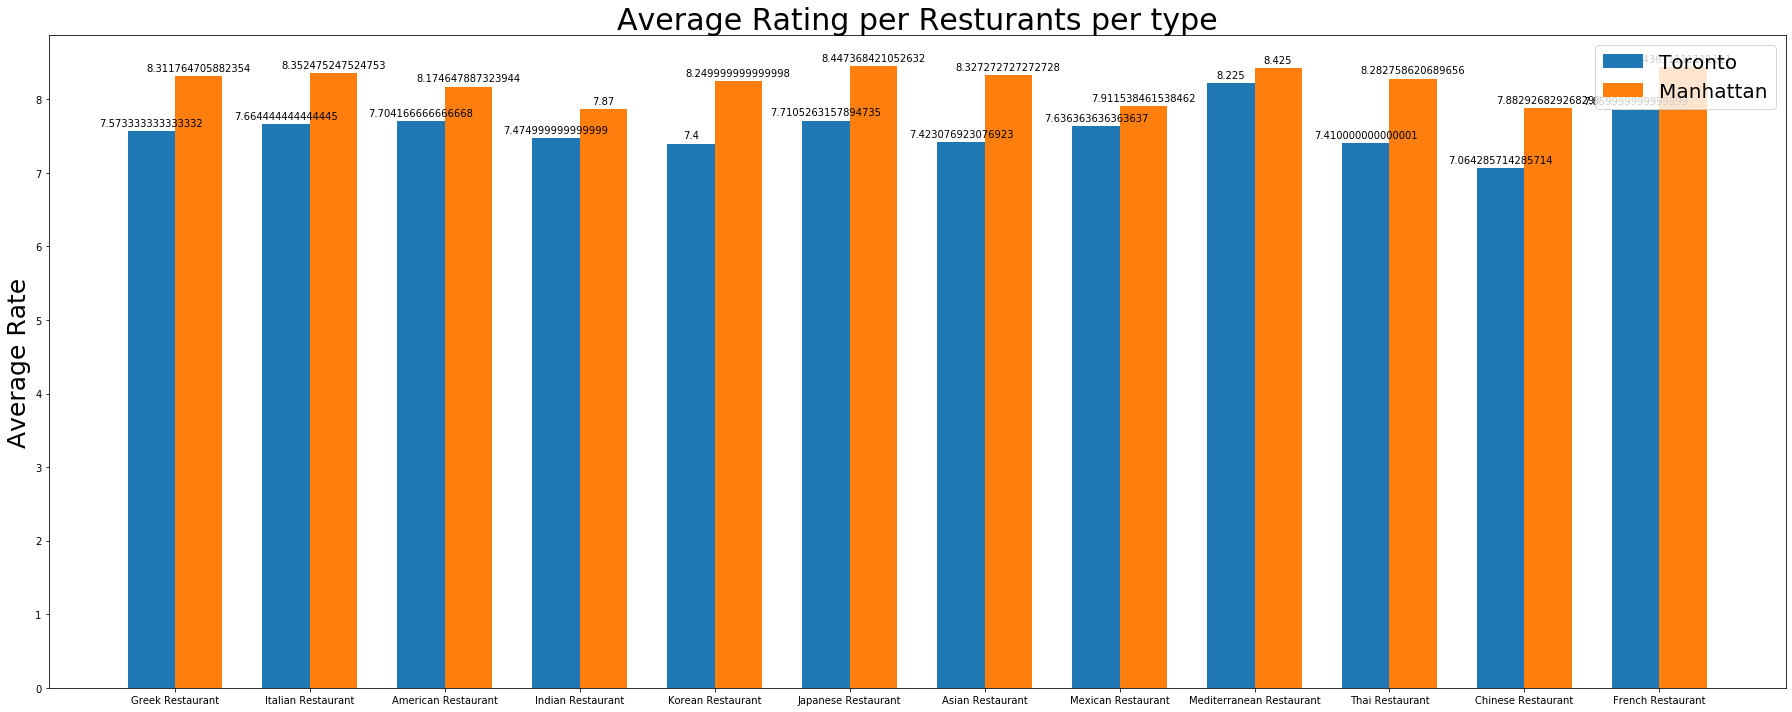

In [84]:
## Get top 10 in Toronto
toronto_top_10 = list(toronto_food['Venue Category'].value_counts().index[0:10])

## Get top 10 in Manhattan
manhattan_top_10 = list(manhattan_food['Venue Category'].value_counts().index[0:10])

## Get top 10 in shared both city 
top_10 = toronto_top_10 + manhattan_top_10
top_10 = list(set(top_10))

# Prepare Data for Grapgh
columns_names = ['category','qty_toronto','qty_manhattan','avg_rate_toronto','avg_rate_manhattan']
graph_df = pd.DataFrame (columns = columns_names)
i = 0
while (i!=len(top_10)):
    category = top_10[i]
    qty_toronto = toronto_food[toronto_food['Venue Category'] == category].shape[0]
    qty_manhattan = manhattan_food[manhattan_food['Venue Category'] == category].shape[0]
    avg_rate_toronto = (toronto_food[toronto_food['Venue Category'] == category]['rating'].sum())/qty_toronto
    avg_rate_manhattan = (manhattan_food[manhattan_food['Venue Category'] == category]['rating'].sum())/qty_manhattan
    graph_df = graph_df.append({'category':category,'qty_toronto':qty_toronto,'qty_manhattan':qty_manhattan,'avg_rate_toronto':avg_rate_toronto,'avg_rate_manhattan':avg_rate_manhattan}, ignore_index=True)
    i = i + 1

#plot line graph 


labels = graph_df['category']
toronto_avg = graph_df['avg_rate_toronto']
manhattan_avg = graph_df['avg_rate_manhattan']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(25,10))
rects1 = ax.bar(x - width/2, toronto_avg, width, label='Toronto')
rects2 = ax.bar(x + width/2, manhattan_avg, width, label='Manhattan')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Rate').set_fontsize(25)
ax.set_title('Average Rating per Resturants per type').set_fontsize(30)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize =10)
ax.legend(fontsize =20)


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

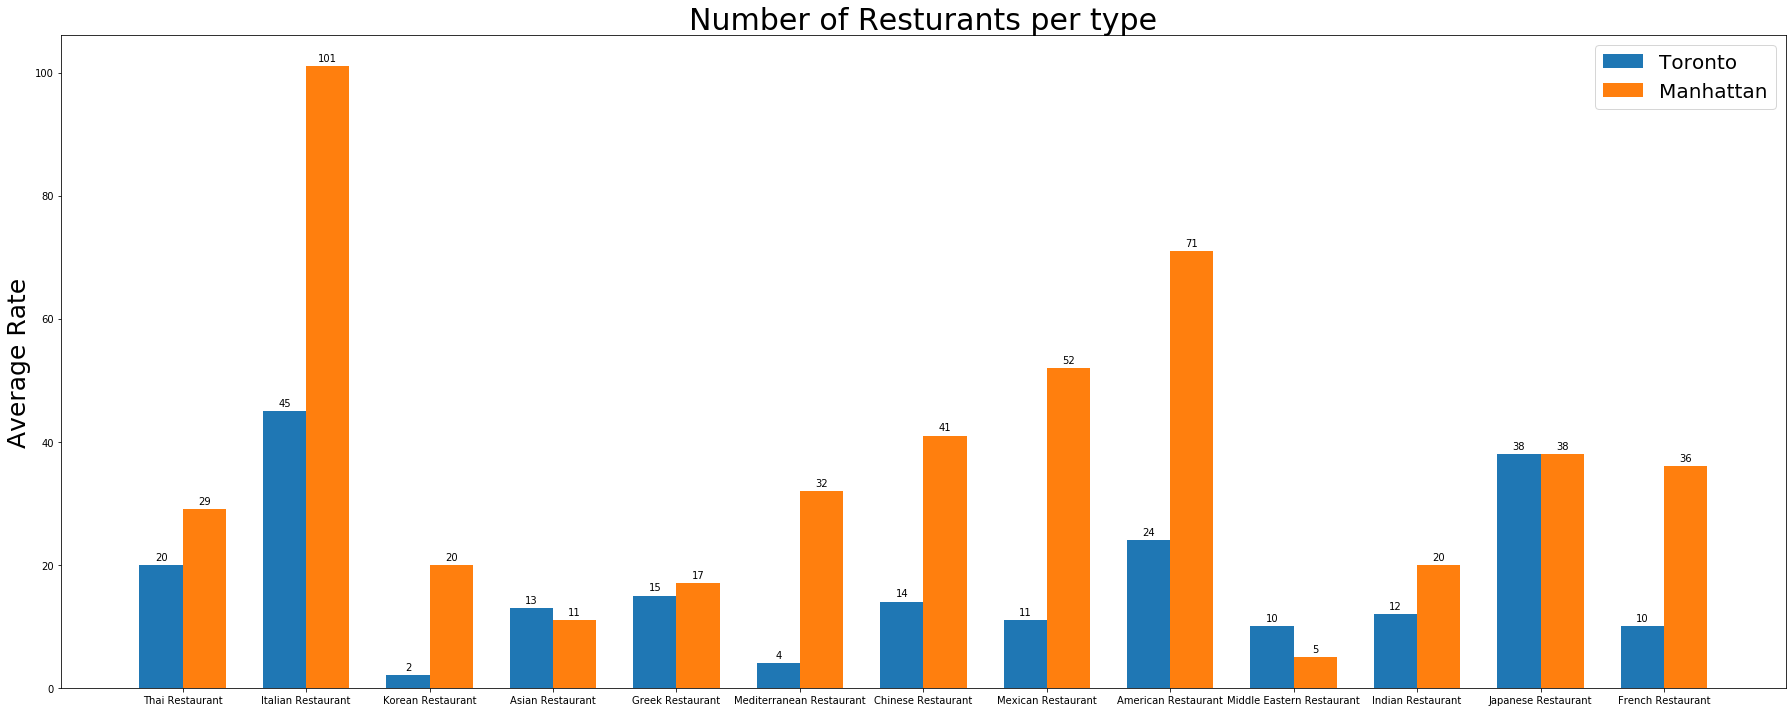

In [339]:
# Graph average Quantity


labels = graph_df['category']
toronto_avg = graph_df['qty_toronto']
manhattan_qty = graph_df['qty_manhattan']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(25,10))
rects1 = ax.bar(x - width/2, toronto_qty, width, label='Toronto')
rects2 = ax.bar(x + width/2, manhattan_qty, width, label='Manhattan')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Rate').set_fontsize(25)
ax.set_title('Number of Resturants per type').set_fontsize(30)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize =10)
ax.legend(fontsize =20)


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

## Multiple Regression Analysis ( Rating as Target)
### Building The Model ( Manhatten)

In [35]:
# Setting On-hot Encoding 
manhattan_onehot = pd.get_dummies(manhattan_venues[['price','is_parking','is_wi_fi','is_reservation','is_outdoor_Seating','Neighborhood']], prefix="", prefix_sep="")

# Concat new columns to original dataframe 
df_concat_manhattan = pd.concat([manhattan_venues, manhattan_onehot], axis=1)

# Split data into training and test sets
from sklearn.model_selection import train_test_split
x_data = df_concat_manhattan[['Moderate','is_parking','is_wi_fi','is_reservation','is_outdoor_Seating']]
y_data = df_concat_manhattan['rating']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state = 0)

# Start building the model
from sklearn import linear_model
regr_manhattan = linear_model.LinearRegression()
regr_manhattan.fit (x_train, y_train)
# The coefficients
print ('Coefficients: ', regr_manhattan.coef_)

##

X_2 = df_concat_manhattan[['Moderate','is_parking','is_wi_fi','is_reservation','is_outdoor_Seating']]
lm_2 = LinearRegression()
Y_2 = df_concat_manhattan[['rating']]
lm_2.fit(X_2,Y_2)
Yhat_2 = lm_2.predict(X_2)
print ('intercept is ',lm_2.intercept_, 'Coef is ', lm_2.coef_)


Coefficients:  [ 1.02373917e-01  6.93889390e-18 -1.38777878e-17  5.63574891e-02
  5.63574891e-02  5.45203168e-02  5.45203168e-02  6.49320900e-03
  6.49320900e-03]
intercept is  [8.12269879] Coef is  [[ 1.06087613e-01  1.38777878e-17 -2.77555756e-17  5.25869104e-02
   5.25869104e-02  5.40940196e-02  5.40940196e-02  1.77127006e-02
   1.77127006e-02]]


In [79]:
toronto_venues[toronto_venues['price'] == 'Very Expensive'].shape[0]/1841*100

1.5752308527973928

In [64]:
toronto_venues.shape

(1841, 20)